<a href="https://colab.research.google.com/github/cemeiq/100-Days-Of-ML-Code/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from argparse import ArgumentParser
import logging
import pickle
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import os


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

In [14]:
!pip install -qq transformers


     |████████████████████████████████| 1.3MB 16.0MB/s 
     |████████████████████████████████| 2.9MB 54.6MB/s 
     |████████████████████████████████| 890kB 51.7MB/s 
     |████████████████████████████████| 1.1MB 45.9MB/s 


In [15]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def save_as_pickle(filename, data):
    completeName = os.path.join("",\
                                filename)
    with open(completeName, 'wb') as output:
        pickle.dump(data, output)


def load_as_pickle(filename):
    completeName = os.path.join("./data/",\
                                filename)
    with open(completeName, 'rb') as pkl_file:
        data = pickle.load(pkl_file)
    return data


import re
def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

                     

In [7]:
testtokenized_concepts = load_as_pickle('/content/test_list_concept_BERT2')
traintokenized_concepts = load_as_pickle('/content/train_list_concept_BERT2')

trains = []
for i in traintokenized_concepts:
    trains.append(untokenize(i))

tests = []
for i in testtokenized_concepts:
    tests.append(untokenize(i))   

In [8]:
train = pd.DataFrame()
test = pd.DataFrame()

In [9]:
train['sentences'] = trains
test['sentences'] = tests

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13748 entries, 0 to 13747
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  13748 non-null  object
dtypes: object(1)
memory usage: 107.5+ KB


In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [17]:
train_token_lens = []
for txt in train.sentences:
  tokens = tokenizer.encode(txt, max_length=512)
  train_token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [18]:
test_token_lens = []
for txt in test.sentences:
  tokens = tokenizer.encode(txt, max_length=512)
  test_token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


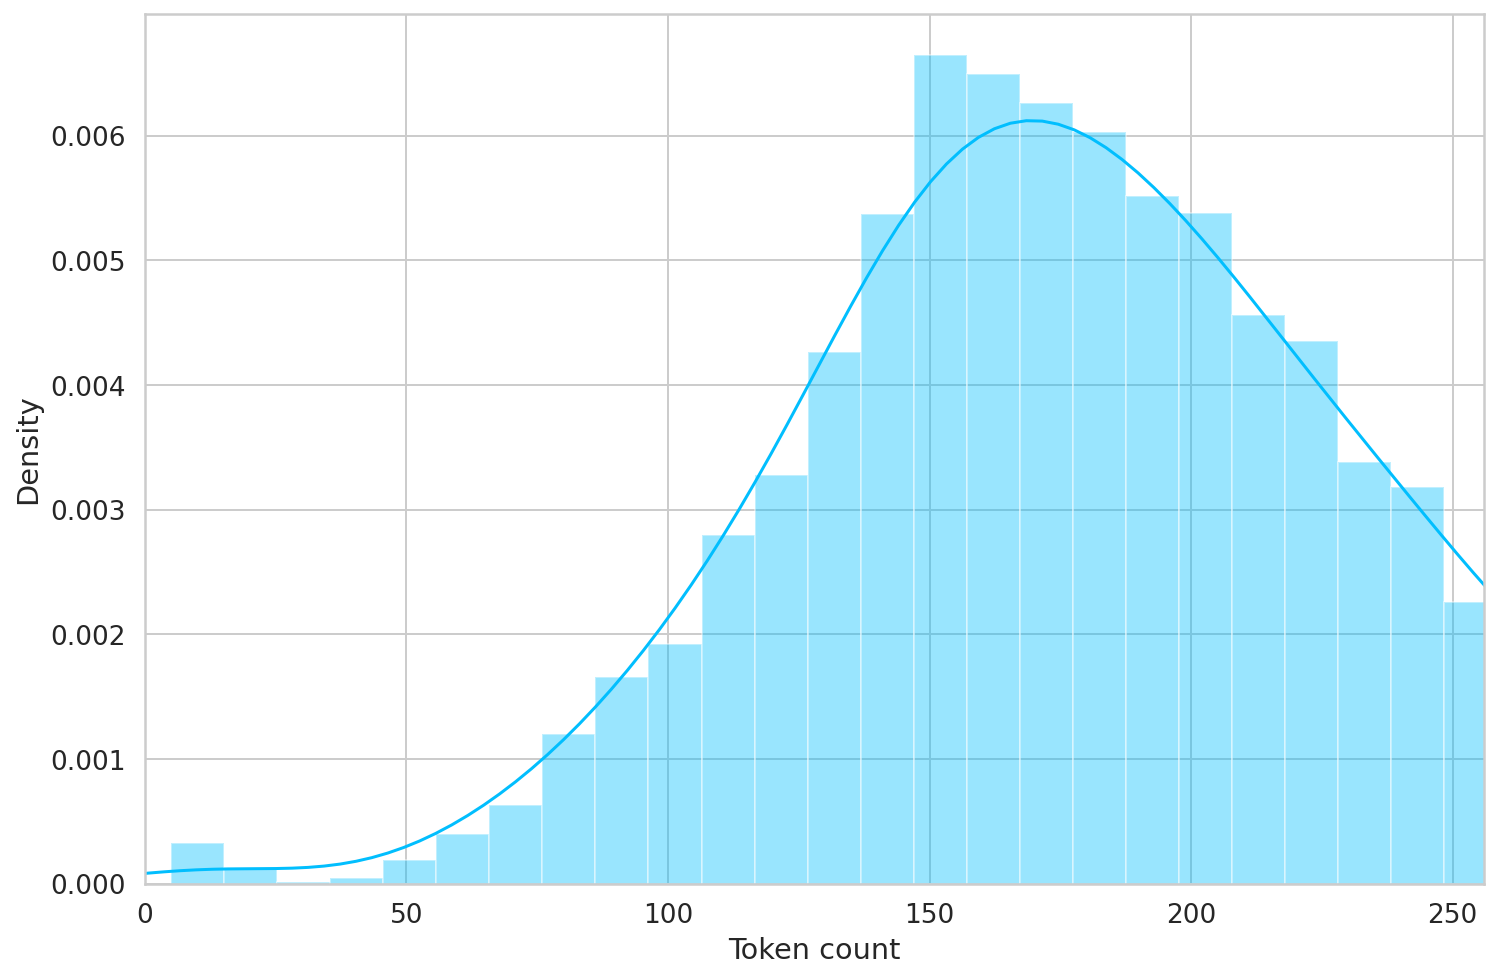

In [19]:
sns.distplot(train_token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [20]:
MAX_LEN = 256

In [24]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, tokenizer, max_len):
    self.reviews = reviews
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten()
      
    }


In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=train.sentences.to_numpy(),
    
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [48]:
BATCH_SIZE*694

11104

In [26]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [27]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask'])

In [28]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [29]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = pooled_output
    return self.out(output)

In [32]:
data = next(iter(train_data_loader))

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [30]:
model = SentimentClassifier(2)

In [31]:
model = model.to(device)


In [33]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


In [34]:
with torch.no_grad():
    top_train_last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')



# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)

In [45]:
train_output = []
for d in train_data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
   
    with torch.no_grad():
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      train_output.append(outputs)


In [ ]:
save_as_pickle('hidden_states_train_output',train_output)
save_as_pickle('features_train_output',new_features)

In [64]:
test_output = []
for d in test_data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
   
    with torch.no_grad():
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      test_output.append(outputs)


RuntimeError: ignored

In [59]:
cnt=0
new_features = []
for i in train_output:
  features = i[0][:,0,:].cpu()
  features = features.numpy()
  for i in features:
    new_features.append(i)
  



In [63]:
cnt=0
test_features = []
for i in test_output:
  features = i[0][:,0,:].cpu()
  features = features.numpy()
  for i in features:
    test_features.append(i)

array([-2.17304364e-01,  8.47179517e-02,  1.63688108e-01, -3.66500765e-02,
       -2.16246396e-01, -2.78740615e-01,  4.36279744e-01, -2.06701666e-01,
        6.21040771e-03, -1.76888689e-01, -6.09901398e-02, -2.51727670e-01,
        1.14647165e-01,  1.32618397e-01, -1.77423447e-01,  3.11562508e-01,
        1.16026655e-01,  2.42383689e-01,  7.06454217e-02,  4.46858257e-02,
        6.53530478e-01, -1.11246951e-01,  1.64320767e-01, -1.34165734e-01,
       -4.21838872e-02,  3.24425161e-01,  7.40871355e-02, -1.47542786e-02,
        1.03428438e-01,  2.79176950e-01, -2.00479150e-01,  6.39982745e-02,
        1.26439378e-01, -2.62474179e-01,  1.17359072e-01,  8.18646699e-02,
        3.84590685e-01, -3.15122753e-02,  3.07613939e-01,  8.22491124e-02,
        7.90269598e-02, -4.93936092e-02,  7.64893591e-02,  1.18566111e-01,
        2.33181491e-02, -7.74493888e-02, -3.09302092e+00,  1.88616980e-02,
       -1.30440131e-01, -3.62635821e-01,  3.17654043e-01, -3.84843983e-02,
       -2.19293252e-01,  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:



# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)



In [ ]:
train_batch = train
test_batch = test

train_tokenized = train_batch['sentences'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True,max_length=70,truncation=True)))
test_tokenized = test_batch['sentences'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True,max_length=70,truncation=True)))

In [ ]:
"""Padding the sentences"""
train_max_len = 0
for i in train_tokenized.values:
    if len(i) > train_max_len:
        train_max_len = len(i)

train_padded = np.array([i + [0]*(train_max_len-len(i)) for i in train_tokenized.values])


In [ ]:
len(train_tokenized[200])

70

In [ ]:
test_max_len = 0
for i in test_tokenized.values:
    if len(i) > test_max_len:
        test_max_len = len(i)

test_padded = np.array([i + [0]*(test_max_len-len(i)) for i in test_tokenized.values])


In [ ]:
train_attention_mask = np.where(train_padded != 0, 1, 0)

test_attention_mask = np.where(test_padded != 0, 1, 0)

In [ ]:
train_input_ids = torch.tensor(train_padded)  
train_attention_mask = torch.tensor(train_attention_mask)



In [ ]:
len(train_input_ids)

11099

In [ ]:
top_train_input_ids = train_input_ids[0:2000,:]
top_train_attention_mask = train_attention_mask[0:2000,:]
 


In [ ]:
with torch.no_grad():
    top_train_last_hidden_states = model(top_train_input_ids, attention_mask=top_train_attention_mask)

AttributeError: ignored

In [ ]:
test_input_ids = torch.tensor(test_padded)  
test_attention_mask = torch.tensor(test_attention_mask)

with torch.no_grad():
    test_last_hidden_states = model(test_input_ids, attention_mask=test_attention_mask)